In [254]:
import current_price as cp
import cryptocompare as cc
import pandas as pd
import requests
import json
from pathlib import Path
import numpy as np
%matplotlib inline
def fetch_daily_data(symbol):
    pair_split = symbol.split('/') # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200: # check to make sure the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s') # convert to a readable date
        data['vol_fiat'] = data['volume'] * data['close']   # multiply the BTC volume by closing price to approximate fiat volume

        # if we failed to get any data, print an error...otherwise write the file
        if data is None:
            print("Did not return any data from Coinbase for this symbol")
        else:
            data.to_csv(f'Coinbase_{pair_split[0] + pair_split[1]}_dailydata.csv', index=False)
    else:
        print("Did not receieve OK response from Coinbase API")

def fetch_main_cryptos():
    if __name__ == "__main__":
  # we set which pair we want to retrieve data for
        pair = "BTC/USD"
        fetch_daily_data(symbol=pair)

    if __name__ == "__main__":
  # we set which pair we want to retrieve data for
        pair = "ETH/USD"
        fetch_daily_data(symbol=pair)

    if __name__ == "__main__":
  # we set which pair we want to retrieve data for
        pair = "LTC/USD"
        fetch_daily_data(symbol=pair)
fetch_main_cryptos()

In [255]:
BTC_path, ETH_path, LTC_path = (Path('Coinbase_BTCUSD_dailydata.csv'),
                                Path('Coinbase_ETHUSD_dailydata.csv'),
                                Path('Coinbase_LTCUSD_dailydata.csv'))
BTC_df, ETH_df, LTC_df = (pd.read_csv(BTC_path, index_col='date', infer_datetime_format=False, parse_dates=True),
                          pd.read_csv(ETH_path, index_col='date', infer_datetime_format=False, parse_dates=True),
                          pd.read_csv(LTC_path, index_col='date', infer_datetime_format=False, parse_dates=True))

# This funtion takes our crypto tickers and returns there immediate price, since cryptos
# are traded outside the normal market hours. We may not even need it, I just added it in here
# for now
def current_price(ticker_string):
    ticker = dict(cryptocompare.get_price(ticker_string,curr='USD',full=False))
    return ticker[ticker_string]['USD']
current_BTC = current_price('BTC')
current_ETH = current_price('ETH')
current_LTC = current_price('LTC')
print(f"BTC/USD: ${current_BTC}\nETH/USD: ${current_ETH}\nLTC/USD: ${current_LTC}")

BTC/USD: $37581.68
ETH/USD: $1192.43
LTC/USD: $145.97


In [256]:
#This function is to create our main datasets. Please edit and comment on how we should approach this.
def clean_data(df):
    df = df.dropna() # immediately drop any null values
    df = df.drop(columns=['unix', 'vol_fiat']).copy() #create deep copy of df with desired columns
    df['volume_change'] = df['volume'].pct_change() #find daily percent change in volume
    df['percent_volatility'] = round(((df['high'] - df['low']) / df['high']) * 100, 2) #Finding the amount of change between the low and high, then comparing it to the high.
    return pd.DataFrame(df)

#these are the base data sets so far
BTC_df = clean_data(BTC_df)
ETH_df = clean_data(ETH_df)
LTC_df = clean_data(LTC_df)



In [257]:
BTC_df.head(1)

,low,high,open,close,volume,volume_change,percent_volatility
date,,,,,,,
2021-01-16,36744.24,37678.23,36754.6,37601.25,1599.656486,NaN,2.48


In [258]:
ETH_df.head(1)

,low,high,open,close,volume,volume_change,percent_volatility
date,,,,,,,
2021-01-16,1168.29,1198.0,1169.04,1192.73,21591.789782,NaN,2.48


In [259]:
LTC_df.head(1)

,low,high,open,close,volume,volume_change,percent_volatility
date,,,,,,,
2021-01-16,143.54,146.49,143.75,145.93,40810.365059,NaN,2.01


In [260]:
#joined columns into new dataframe and renamed
BTC_volume = BTC_df['volume_change']
ETH_volume = ETH_df['volume_change']
LTC_volume = LTC_df['volume_change']
volume_change_df = pd.concat([BTC_volume, ETH_volume, LTC_volume], axis=1)
volume_change_df.columns = ['BTC_volume_change', 'ETH_volume_change', 'LTC_volume_change']


In [261]:
#there is a high volume difference for the most recent volume_change because it is compared against current(which hasnt ended) and previous volume.
volume_change_df.head()

,BTC_volume_change,ETH_volume_change,LTC_volume_change
date,,,
2021-01-16,NaN,NaN,NaN
2021-01-15,21.768050,25.808425,16.992866
2021-01-14,-0.124991,-0.242509,0.012093
2021-01-13,0.242870,0.151558,0.168073
2021-01-12,0.217601,0.299960,0.326414


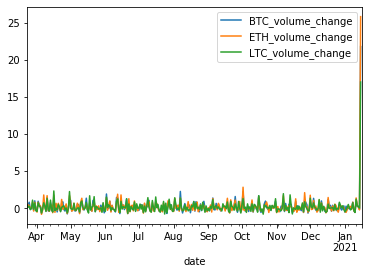

In [262]:
#but it really messes with the graph, which would show us volume trends
#so we just need a way to remove the most recent index, since the data is incomplete
volume_change_df.plot()

In [263]:
#joined columns into new dataframe and renamed
BTC_volatility = BTC_df['percent_volatility']
ETH_volatility = ETH_df['percent_volatility']
LTC_volatility = LTC_df['percent_volatility']
volatility_df = pd.concat([BTC_volatility, ETH_volatility, LTC_volatility], axis=1)
volatility_df.columns = ['BTC_volatility', 'ETH_volatility', 'LTC_volatility']

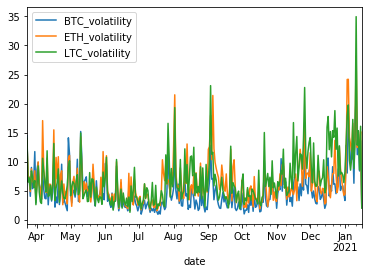

In [264]:
#shows us trend line of high and low volatility
volatility_df.plot()

In [265]:

#joined columns into new dataframe and renamed
BTC_close = BTC_df['close']
ETH_close = ETH_df['close']
LTC_close = LTC_df['close']
close_df = pd.concat([BTC_close, ETH_close, LTC_close], axis=1)
close_df.columns = ['BTC_close', 'ETH_close', 'LTC_close']

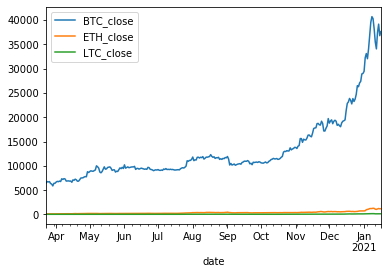

In [266]:
#daily stock prices
close_df.plot()

In [267]:
#daily stock prices
